# Imports

In [1]:
%run functions_sentiments.ipynb

In [2]:
import pandas as pd
import numpy as np
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import dask.dataframe as dd
try:
    import swifter
except ModuleNotFoundError: 
    !pip install swifter
    
try:
    import pycountry 
except ModuleNotFoundError:
    !pip install pycountry

# Data Processing

## Load Data

In [3]:
link = "./march/UkraineCombinedTweetsDeduped_MAR19.csv"
df = pd.read_csv(link)

# remove nans 
df = df[df['location'].notnull()]
# keep only en language
df = df[df['language'] == 'en']
# drop uneccesary cols
dropped_cols = ['Unnamed: 0', 'following', 'followers', 'tweetid', 'retweetcount', 'usercreatedts',
                'totaltweets', 'acctdesc', 'language', 'username', 'coordinates', 'favorite_count']
df.drop(dropped_cols, inplace=True, axis=1)
# Convert to date-time
df['tweetcreatedts'] = pd.to_datetime(df['tweetcreatedts'], errors='coerce', infer_datetime_format=True).dt.date
df.head()

userid      location tweetcreatedts  \
1  1495021491297136647   switzerland     2022-03-19   
2            843239474       Ukraine     2022-03-19   
3   915002523584487424  New York, NY     2022-03-19   
4            180748385         India     2022-03-19   
5            152930351            UK     2022-03-19   

                                                text  \
1  "Violence is the weapon of the weak, non-viole...   
2  The russian Occupiers dropped a super-powerful...   
3  Putin Calls Russians Who Sympathize With The W...   
4  Strong sanctions on #Moscow will likely compli...   
5  The #Anonymous collective has sent 7.000.000 a...   

                                            hashtags  \
1  [{'text': 'LetsPrayTogether', 'indices': [89, ...   
2  [{'text': 'StopRussia', 'indices': [123, 134]}...   
3  [{'text': 'Putin', 'indices': [61, 67]}, {'tex...   
4  [{'text': 'Moscow', 'indices': [20, 27]}, {'te...   
5       [{'text': 'Anonymous', 'indices': [21, 31]}]   

                  extractedts  
1  2022-03-19 00:06:57.230341  
2  2022-03-19 00:21:28.162213  
3  2022-03-19 00:21:28.154032  
4  2022-03-19 00:21:28.146142  
5  2022-03-19 00:06:57.150039

## Data Cleaning

In [4]:
## Setting up the function to extract country name from text
countries = pd.DataFrame()
countries['country'] = [text_processing(c.name) for c in pycountry.countries]
countries['country_code'] = [text_processing(c.alpha_3).lower() for c in pycountry.countries]
import re
try:
    import pycountry 
except ModuleNotFoundError:
    !pip install pycountry

def get_country(text):
    words = text.split()
    for w in words:
        found = False
        if w in list(countries['country']):
            found = True
            return(w) 
        elif w in list(countries['country_code']) and not found:
            return countries[countries['country_code'] == w]['country'].values[0]
    return('No')

In [5]:
# clean location
df['location_clean'] = df['location'].swifter.apply(text_processing)
df['country'] = df['location_clean'].swifter.apply(get_country)
df = df[df['country'] != 'No']

# clean text
df['text'] = df['text'].astype(str)
df['text_clean'] = df['text'].swifter.apply(text_processing)
df['text_clean'] = df['text_clean'].swifter.apply(remove_urls)

df.head()

Pandas Apply:   0%|          | 0/181836 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181836 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38016 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38016 [00:00<?, ?it/s]

userid                      location tweetcreatedts  \
2            843239474                       Ukraine     2022-03-19   
4            180748385                         India     2022-03-19   
12           369869874  Nariman Point, Mumbai, India     2022-03-19   
23  979060763674447874                        Rwanda     2022-03-19   
24  818338385731485700                        Cyprus     2022-03-19   

                                                 text  \
2   The russian Occupiers dropped a super-powerful...   
4   Strong sanctions on #Moscow will likely compli...   
12  .@SaaranshM04 &amp; @RheaSinha12 write on how ...   
23  @KyivIndependent But, how many times is #Macro...   
24  Amid the chaos of rocketing #energy prices, we...   

                                             hashtags  \
2   [{'text': 'StopRussia', 'indices': [123, 134]}...   
4   [{'text': 'Moscow', 'indices': [20, 27]}, {'te...   
12  [{'text': 'Pakistan', 'indices': [106, 115]}, ...   
23  [{'text': 'Macron', 'indices': [40, 47]}, {'te...   
24  [{'text': 'energy', 'indices': [28, 35]}, {'te...   

                   extractedts              location_clean  country  \
2   2022-03-19 00:21:28.162213                     Ukraine  Ukraine   
4   2022-03-19 00:21:28.146142                       India    India   
12  2022-03-19 00:06:56.935732  Nariman Point Mumbai India    India   
23  2022-03-19 00:21:28.098002                      Rwanda   Rwanda   
24  2022-03-19 00:06:56.598722                      Cyprus   Cyprus   

                                           text_clean  
2   The Occupiers dropped super powerful bomb dram...  
4   Strong sanction Moscow likely complicate South...  
12  write India reason fazed growing tie Pakistan ...  
23  But time Macron going Putin World end It doesn...  
24  Amid chaos rocketing energy price checking fut...

## Group Data

In [9]:
df_count_tweets = df.groupby('userid', as_index=False).count() \
                                    .sort_values(by='text_clean', ascending=False)[['userid', 'text_clean']]

df_count_tweets = df_count_tweets.rename(columns = {'text_clean': '#daily_tweets'})
df_all = df.merge(df_count_tweets, on ='userid', how='inner')

df_all.head(2)

userid location tweetcreatedts  \
0  843239474  Ukraine     2022-03-19   
1  843239474  Ukraine     2022-03-19   

                                                text  \
0  The russian Occupiers dropped a super-powerful...   
1  As a result of the shelling by russian invader...   

                                            hashtags  \
0  [{'text': 'StopRussia', 'indices': [123, 134]}...   
1  [{'text': 'StopRussia', 'indices': [155, 166]}...   

                  extractedts location_clean  country  \
0  2022-03-19 00:21:28.162213        Ukraine  Ukraine   
1  2022-03-19 00:21:21.277675        Ukraine  Ukraine   

                                          text_clean  #daily_tweets  
0  The Occupiers dropped super powerful bomb dram...             24  
1  As result shelling invader city Merefa Ukraine...             24

In [10]:
df_grouped_tweets = df.groupby(['userid'])['text_clean'].apply(lambda x: ','.join(x)).reset_index()
df_all = df_all.merge(df_grouped_tweets, on='userid', how='inner', suffixes=('_individual', '_all'))
df_all = df_all.drop_duplicates(subset=['text_clean_all'])
df_all.drop(['text_clean_individual', 'text', 'location_clean'], axis=1, inplace=True)
df_all.drop_duplicates(subset=['text_clean_all']).sort_values(by='#daily_tweets', ascending=False)

# group by country
df_all = df_all.groupby(['country', 'tweetcreatedts'])['text_clean_all'].apply(lambda x: ','.join(x)).reset_index()
df_all.sort_values(by='country', ascending=False)

# count words
df_all['count_words'] = df_all['text_clean_all'].apply(len)

# keep countries with count_words > threshold 
df_all = df_all[df_all['count_words'] > 1500]
df_all

country tweetcreatedts  \
0      Afghanistan     2022-03-19   
1          Albania     2022-03-19   
2          Algeria     2022-03-19   
5       Antarctica     2022-03-19   
6        Argentina     2022-03-19   
..             ...            ...   
145  United States     2022-03-19   
146        Uruguay     2022-03-19   
148          Yemen     2022-03-19   
150       Zimbabwe     2022-03-19   
152          union     2022-03-19   

                                        text_clean_all  count_words  
0    May ask did message stop war Afghanistan toke ...         3287  
1    Ukrainian Theater War Day 22 23 The fourth wee...         3270  
2    Nebenzia Representatives US Department State c...         5623  
5    Video Ukrainian Drone dropped Munition Attacks...         7003  
6    NATO Expansion,Static image 0000 UTC Saturday ...        20892  
..                                                 ...          ...  
145  Ukrainian Destroy Russian Tank using Stugna an...         5729  
146  Pop music legend Cher said ready shelter Ukrai...         4914  
148  President Putin At start operation Donbass Kie...         7909  
150  Never forget Republicans chance impeach convic...         8803  
152  War criminal Putin wanted redraw military poli...         2067  

[103 rows x 4 columns]

# Text Analytics

## Word Cloud

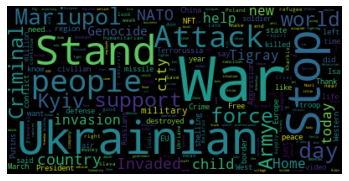

In [11]:
corpus = ' '.join(df_all['text_clean_all'].tolist())
from wordcloud import WordCloud
from matplotlib.pyplot import figure

my_cloud = WordCloud(stopwords=stop_words, collocations=False).generate(corpus)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")

# Don't forget to show the final image
plt.show()

## Sentiment Analysis

In [12]:
df_all['sentiment_analysis'] = df_all['text_clean_all'].swifter.apply(sentiment_scores)
df_all['positive'] = df_all['sentiment_analysis'].apply(lambda row: row['pos'])
df_all['neutral'] = df_all['sentiment_analysis'].apply(lambda row: row['neu'])
df_all['negative'] = df_all['sentiment_analysis'].apply(lambda row: row['neg'])
df_all['compound'] = df_all['sentiment_analysis'].apply(lambda row: row['compound'])
df_all = df_all.merge(countries)
df_all

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

country tweetcreatedts  \
0      Afghanistan     2022-03-19   
1          Albania     2022-03-19   
2          Algeria     2022-03-19   
3       Antarctica     2022-03-19   
4        Argentina     2022-03-19   
..             ...            ...   
98   United States     2022-03-19   
99         Uruguay     2022-03-19   
100          Yemen     2022-03-19   
101       Zimbabwe     2022-03-19   
102          union     2022-03-19   

                                        text_clean_all  count_words  \
0    May ask did message stop war Afghanistan toke ...         3287   
1    Ukrainian Theater War Day 22 23 The fourth wee...         3270   
2    Nebenzia Representatives US Department State c...         5623   
3    Video Ukrainian Drone dropped Munition Attacks...         7003   
4    NATO Expansion,Static image 0000 UTC Saturday ...        20892   
..                                                 ...          ...   
98   Ukrainian Destroy Russian Tank using Stugna an...         5729   
99   Pop music legend Cher said ready shelter Ukrai...         4914   
100  President Putin At start operation Donbass Kie...         7909   
101  Never forget Republicans chance impeach convic...         8803   
102  War criminal Putin wanted redraw military poli...         2067   

                                    sentiment_analysis  positive  neutral  \
0    {'neg': 0.296, 'neu': 0.582, 'pos': 0.122, 'co...     0.122    0.582   
1    {'neg': 0.263, 'neu': 0.622, 'pos': 0.115, 'co...     0.115    0.622   
2    {'neg': 0.146, 'neu': 0.683, 'pos': 0.171, 'co...     0.171    0.683   
3    {'neg': 0.249, 'neu': 0.673, 'pos': 0.079, 'co...     0.079    0.673   
4    {'neg': 0.243, 'neu': 0.635, 'pos': 0.123, 'co...     0.123    0.635   
..                                                 ...       ...      ...   
98   {'neg': 0.148, 'neu': 0.731, 'pos': 0.122, 'co...     0.122    0.731   
99   {'neg': 0.206, 'neu': 0.722, 'pos': 0.072, 'co...     0.072    0.722   
100  {'neg': 0.189, 'neu': 0.736, 'pos': 0.075, 'co...     0.075    0.736   
101  {'neg': 0.227, 'neu': 0.685, 'pos': 0.089, 'co...     0.089    0.685   
102  {'neg': 0.276, 'neu': 0.583, 'pos': 0.141, 'co...     0.141    0.583   

     negative  compound country_code  
0       0.296   -0.9988          afg  
1       0.263   -0.9979          alb  
2       0.146    0.1224          dza  
3       0.249   -0.9997          ata  
4       0.243   -0.9999          arg  
..        ...       ...          ...  
98      0.148   -0.8810          usa  
99      0.206   -0.9983          ury  
100     0.189   -0.9994          yem  
101     0.227   -0.9997          zwe  
102     0.276   -0.9957          reu  

[103 rows x 10 columns]

# Export Data

In [13]:
date = df_all['tweetcreatedts'].dt.date.iloc[0]
title = "df_sentiments_" + f"{date}" + ".csv"
df_all.to_csv("./sentiments_clean/"+title)

In [14]:
df_all.head()

country tweetcreatedts  \
0  Afghanistan     2022-03-19   
1      Albania     2022-03-19   
2      Algeria     2022-03-19   
3   Antarctica     2022-03-19   
4    Argentina     2022-03-19   

                                      text_clean_all  count_words  \
0  May ask did message stop war Afghanistan toke ...         3287   
1  Ukrainian Theater War Day 22 23 The fourth wee...         3270   
2  Nebenzia Representatives US Department State c...         5623   
3  Video Ukrainian Drone dropped Munition Attacks...         7003   
4  NATO Expansion,Static image 0000 UTC Saturday ...        20892   

                                  sentiment_analysis  positive  neutral  \
0  {'neg': 0.296, 'neu': 0.582, 'pos': 0.122, 'co...     0.122    0.582   
1  {'neg': 0.263, 'neu': 0.622, 'pos': 0.115, 'co...     0.115    0.622   
2  {'neg': 0.146, 'neu': 0.683, 'pos': 0.171, 'co...     0.171    0.683   
3  {'neg': 0.249, 'neu': 0.673, 'pos': 0.079, 'co...     0.079    0.673   
4  {'neg': 0.243, 'neu': 0.635, 'pos': 0.123, 'co...     0.123    0.635   

   negative  compound country_code  
0     0.296   -0.9988          afg  
1     0.263   -0.9979          alb  
2     0.146    0.1224          dza  
3     0.249   -0.9997          ata  
4     0.243   -0.9999          arg